In [1]:
import numpy as np
import scipy
from scipy.optimize.elementwise import find_root
import matplotlib.pyplot as plt

# BBH mass distribution

In [2]:
def bbh_mass1_distribution(m1, alpha, mu_m1, sigma_m1, f_p, M_min, M_max):
    result = np.where((M_min < m1) & (m1 < M_max),
                      (1 - f_p) * m1 ** alpha + f_p * scipy.stats.norm.pdf(m1, mu_m1, sigma_m1), 0)
    norm = np.trapezoid(result, m1)

    return result / norm

In [3]:
alpha = -3.5
mu_m1 = 34
sigma_m1 = 3
f_p = 1e-3
M_min = 5
M_max = 100

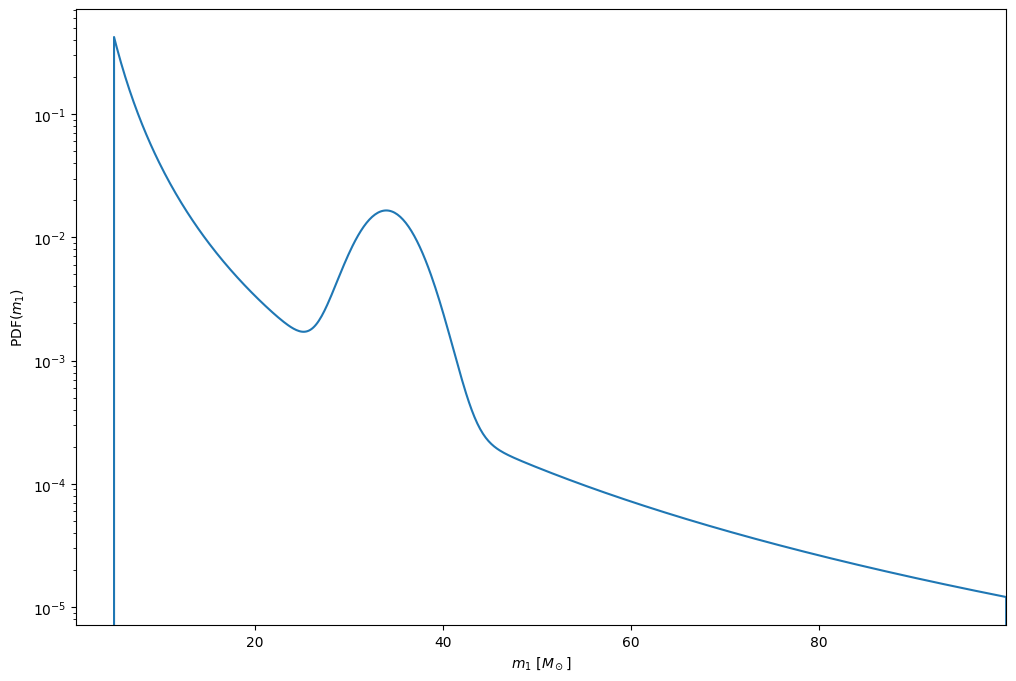

In [4]:
m1 = np.linspace(1, 150, 1000)
pdf_m1 = bbh_mass1_distribution(m1, alpha, mu_m1, sigma_m1, f_p, M_min, M_max)

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_xlabel(r'$m_1\ [M_\odot]$')
ax.set_ylabel(r'$\text{PDF}(m_1)$')

ax.set_yscale('log')

ax.plot(m1, pdf_m1)

ax.autoscale(axis='x', tight=True)
ax.set_xlim(ax.get_xlim()[0], m1[m1 < 100][-1])

plt.show()

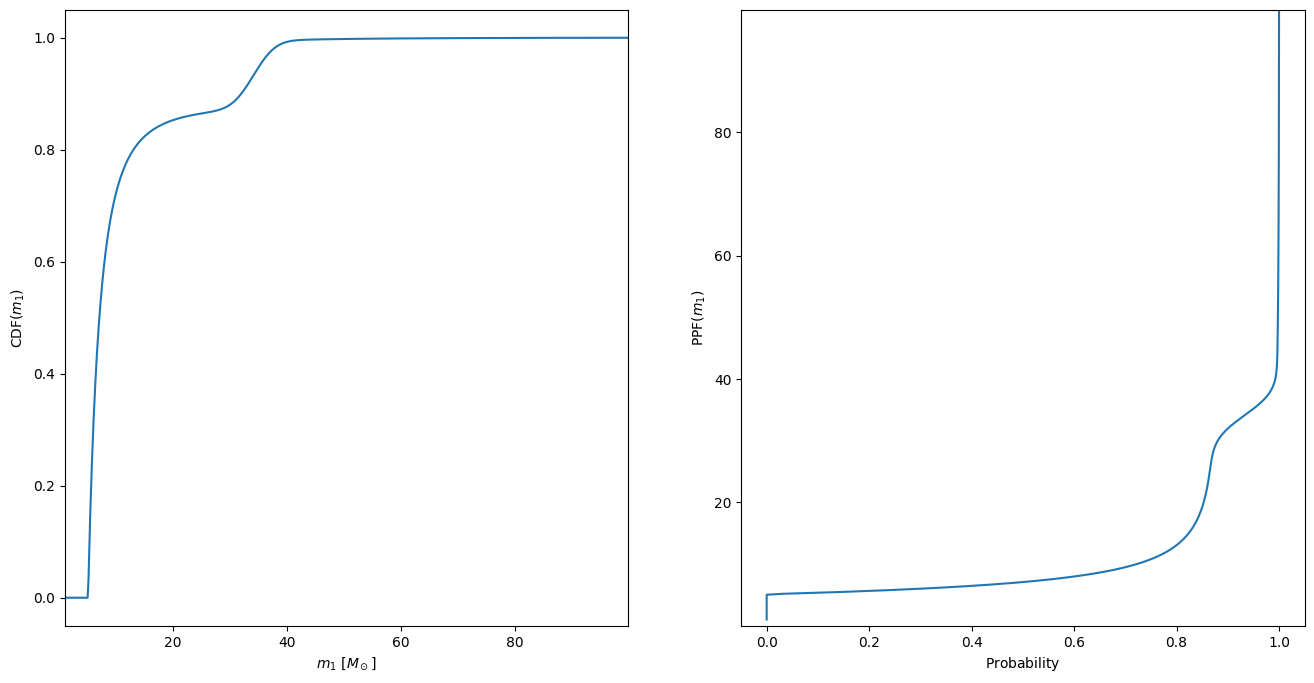

In [5]:
cdf_m1 = np.array([np.trapezoid(pdf_m1[:i], m1[:i]) for i in range(len(m1))])

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].set_xlabel(r'$m_1\ [M_\odot]$')
axes[0].set_ylabel(r'$\text{CDF}(m_1)$')

axes[1].set_xlabel(r'$\text{Probability}$')
axes[1].set_ylabel(r'$\text{PPF}(m_1)$')

axes[0].plot(m1, cdf_m1)
axes[1].plot(cdf_m1, m1)

axes[0].autoscale(axis='x', tight=True)
axes[0].set_xlim(ax.get_xlim()[0], m1[m1 < 100][-1])

axes[1].autoscale(axis='y', tight=True)
axes[1].set_ylim(ax.get_ylim()[0], m1[m1 < 100][-1])

plt.show()

# Bin comparison

1. Consider two independent observations of the BBH mass distribution.
2. Choose the same mass bin in both of the observations.
3. The underlying number of events in each bin is Poisson distributed: $\text{Pois}(N, \lambda) = \dfrac{\lambda^N \exp(-\lambda)}{N!}$.
4. Suppose $N_1$ and $N_2$ counts. How confidently can I say that $N_1 \neq N_2$?

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_63775/891852472.py:6: RuntimeWarning: overflow encountered in power
  p_n_events_1 = expected_n_events_1 ** n_events * np.exp(-expected_n_events_1) / scipy.special.gamma(n_events + 1)
/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_63775/891852472.py:6: RuntimeWarning: invalid value encountered in divide
  p_n_events_1 = expected_n_events_1 ** n_events * np.exp(-expected_n_events_1) / scipy.special.gamma(n_events + 1)
/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_63775/891852472.py:7: RuntimeWarning: overflow encountered in power
  p_n_events_2 = expected_n_events_2 ** n_events * np.exp(-expected_n_events_2) / scipy.special.gamma(n_events + 1)
/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_63775/891852472.py:7: RuntimeWarning: invalid value encountered in divide
  p_n_events_2 = expected_n_events_2 ** n_events * np.exp(-expected_n_events_2) / scipy.special.gamma(n_events + 1)


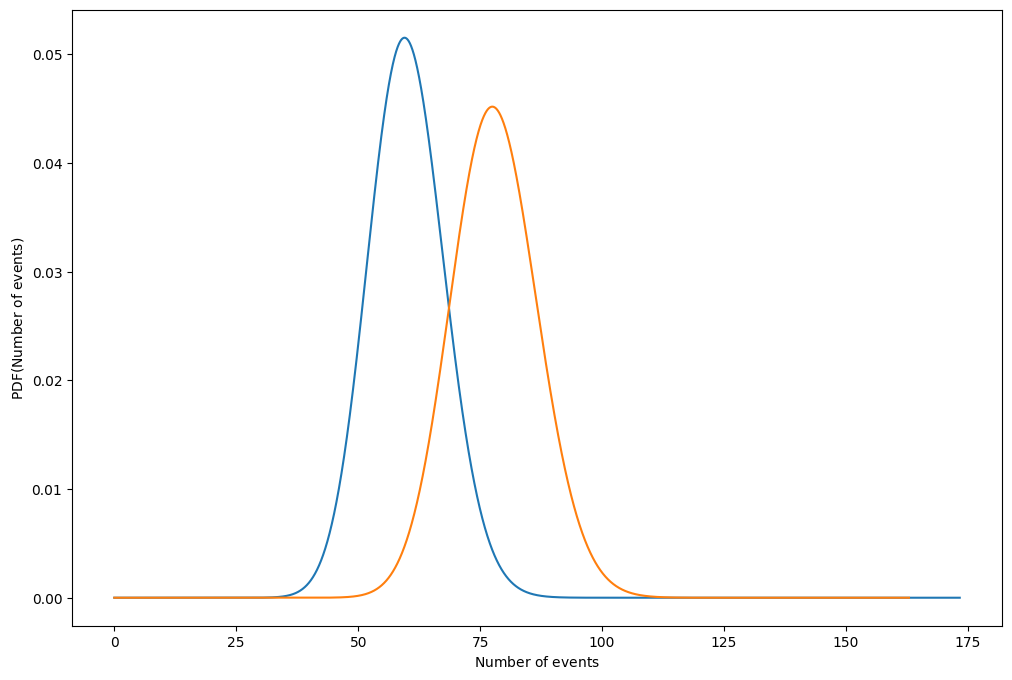

In [6]:
expected_n_events_1 = 60
k = 1.3
expected_n_events_2 = k * expected_n_events_1

n_events = np.linspace(0, 300, 10000)
p_n_events_1 = expected_n_events_1 ** n_events * np.exp(-expected_n_events_1) / scipy.special.gamma(n_events + 1)
p_n_events_2 = expected_n_events_2 ** n_events * np.exp(-expected_n_events_2) / scipy.special.gamma(n_events + 1)

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_xlabel(r'$\text{Number of events}$')
ax.set_ylabel(r'$\text{PDF}(\text{Number of events})$')

ax.plot(n_events, p_n_events_1)
ax.plot(n_events, p_n_events_2)

plt.show()

In [7]:
cl = 0.05 # Confidence level

## Binomial test

If $X_1 \sim \text{Pois}(\lambda_1)$ and $X_2 \sim \text{Pois}(\lambda_2)$ are independent, then the distribution of $X_1$ conditional on $X_1 + X_2$ is a binomial distribution: $\text{Bin}(k, n, p) = {n\choose k} p^k (1-p)^{n-k}$. Specifically, if $X_1 + X_2 = N_1 + N_2$, then $X_1 | (X_1 + X_2) \sim \text{Bin}\left(N_1 + N_2, \dfrac{\lambda_1}{\lambda_1 + \lambda_2}\right)$.

If I observe $N_1$ and $N_2$, then $\lambda_1 = N_1$ and $\lambda_2 = N_2$. Introducing $\alpha = \dfrac{N_1}{N_2} = \dfrac{\lambda_1}{\lambda_2}$: $X_1 | (X_1 + X_2) \sim \text{Bin}\left(N_1 + N_2, \dfrac{\alpha}{1 + \alpha}\right)$

What is the probability to observe in bin $1$ $N_1^\ast \geq \lambda_1 = N_1$?
That is $P(N_1^\ast \geq \lambda_1 | N_1 + N_2 = \lambda_1 + \lambda_2) = \sum_{k = N_1}^{N_1 + N_2} {{N_1 + N_2}\choose k} \left(\dfrac{\alpha}{1 + \alpha}\right)^k \left(\dfrac{1}{1 + \alpha}\right)^{N_1 + N_2 - k}$, or:

$$P(N_1^\ast \geq \lambda_1 | N_1 + N_2 = \lambda_1 + \lambda_2) = \dfrac{1}{(1 + \alpha)^{N_1 + N_2}} \sum_{k = N_1}^{N_1 + N_2} {{N_1 + N_2}\choose k} \alpha^k$$

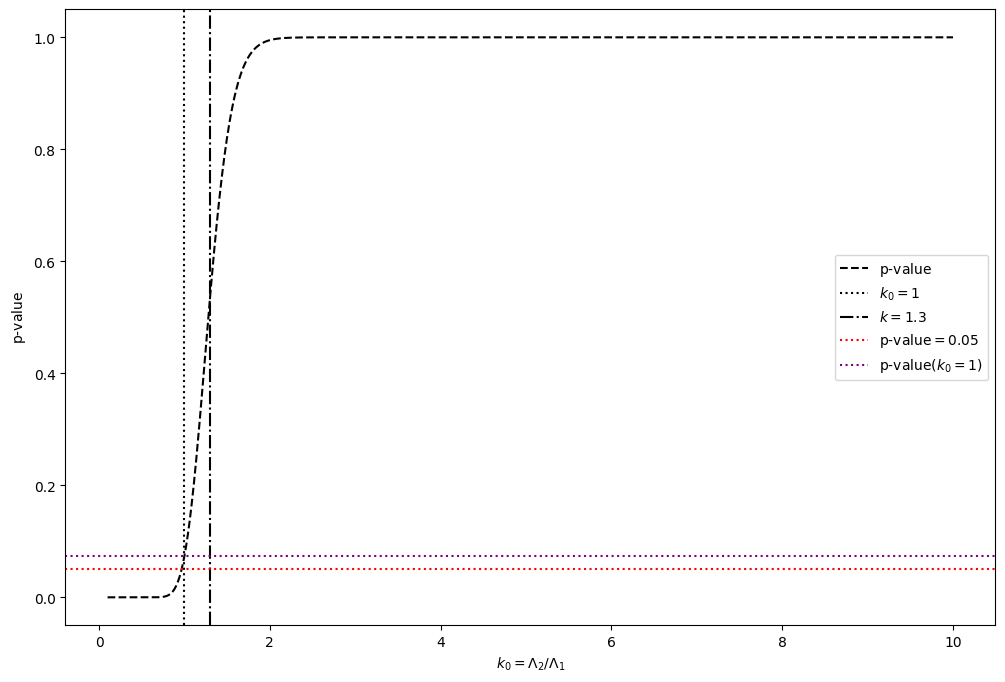

In [8]:
k_0 = np.linspace(0.1, 10, 1000)

def p_value_bin(k_0, expected_n_events_1, expected_n_events_2):
    return sum([scipy.special.binom(expected_n_events_1 + expected_n_events_2, i) *\
                k_0 ** i / (1 + k_0) ** (expected_n_events_1 + expected_n_events_2)
                for i in range(int(expected_n_events_2), int(expected_n_events_1 + expected_n_events_2) + 1)])

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_xlabel(r'$k_0 = \Lambda_2 / \Lambda_1$')
ax.set_ylabel(r'$\text{p-value}$')

ax.plot(k_0, p_value_bin(k_0, expected_n_events_1, expected_n_events_2), linestyle='--', color='black', label=r'$\text{p-value}$')

ax.axvline(1, linestyle=':', color='black', label=r'$k_0 = 1$')
ax.axvline(k, linestyle='-.', color='black', label=r'$k = {0}$'.format(k))
ax.axhline(cl, linestyle=':', color='red', label=r'$\text{p-value} = 0.05$')
ax.axhline(p_value_bin(1, expected_n_events_1, expected_n_events_2), linestyle=':', color='purple', label=r'$\text{p-value}(k_0 = 1)$')

ax.legend()

plt.show()

## Likelihood-ratio test

My likelihood is $\mathcal{L}(\lambda_1, \lambda_2) = \text{Pois}(\lambda_1) \times \text{Pois}(\lambda_2)$, where $\lambda_1 = N_1$ and $\lambda_2 = N_2$.
Introducing $\alpha = \dfrac{N_1}{N_2} = \dfrac{\lambda_1}{\lambda_2}$:
$$\mathcal{L}(\alpha, \lambda_2) = \dfrac{(\alpha \lambda_2)^{N_1}}{N_1!} \exp(-\alpha \lambda_2) \dfrac{\lambda_2^{N_2}}{N_2!} \exp(-\lambda_2)$$

Denote $\Theta = \{\alpha, \lambda_2\}$ the parameter space. The likelihood-ratio test statistic for the null hypothesis $H_0 : \theta \in \Theta_0$ is given by:
$$\lambda_\text{LR} = -2 \ln\left[\dfrac{\sup_{\theta \in \Theta_0} \mathcal{L}(\theta)}{\sup_{\theta \in \Theta} \mathcal{L}(\theta)}\right]$$
where $\Theta_0 = \{\alpha = \alpha_0, \lambda_2\}$. $\lambda_\text{LR}$ is asymptotically $\chi^2$ distributed.

In our case:
$$\lambda_\text{LR} = 2 N_2 \left[\alpha\ln\left(\dfrac{\alpha}{\alpha_0}\right) - \left(1 + \alpha\right) \ln\left(\dfrac{1 + \alpha}{1 + \alpha_0}\right)\right]$$

In our case we have $2 - 1 = 1$ degrees of freedom: if $\text{p-value} = P(\chi^2_1 > \lambda_\text{LR}) < \text{c.l.} \Longrightarrow \alpha \neq \alpha_0$

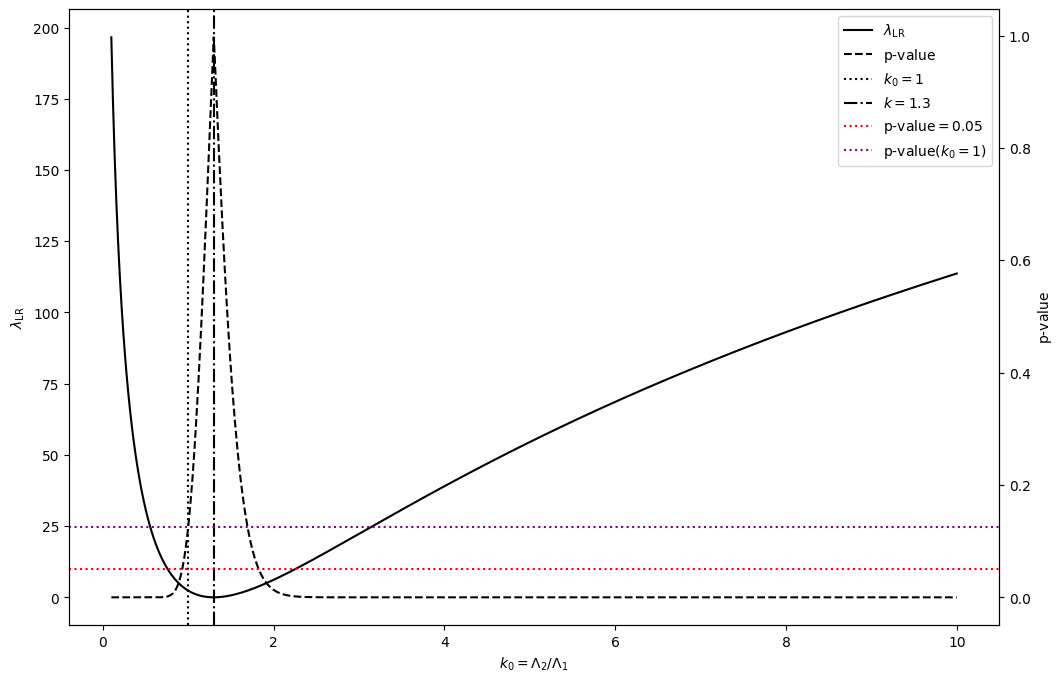

In [9]:
k_0 = np.linspace(0.1, 10, 1000)

def lambda_LR(k_0, k, expected_n_events_1):
    return 2 * expected_n_events_1 * (k * np.log(k / k_0) - (1 + k) * np.log((1 + k) / (1 + k_0)))

p_value_LR = scipy.stats.chi2.sf(lambda_LR(k_0, k, expected_n_events_1), 1)

fig, ax = plt.subplots(figsize=(12, 8))

twin_ax = ax.twinx()

twin_ax.set_ylabel(r'$\text{p-value}$')

ax.set_xlabel(r'$k_0 = \Lambda_2 / \Lambda_1$')
ax.set_ylabel(r'$\lambda_\text{LR}$')

lines = []

lines.append(ax.plot(k_0, lambda_LR (k_0, k, expected_n_events_1), color='black', label=r'$\lambda_\text{LR}$')[0])
lines.append(twin_ax.plot(k_0, p_value_LR, linestyle='--', color='black', label=r'$\text{p-value}$')[0])
lines.append(ax.axvline(1, linestyle=':', color='black', label=r'$k_0 = 1$'))
lines.append(ax.axvline(k, linestyle='-.', color='black', label=r'$k = {0}$'.format(k)))
lines.append(twin_ax.axhline(cl, linestyle=':', color='red', label=r'$\text{{p-value}} = {0}$'.format(cl)))
lines.append(twin_ax.axhline(scipy.stats.chi2.sf(lambda_LR(1, k, expected_n_events_1), 1), linestyle=':', color='purple', label=r'$\text{p-value}(k_0 = 1)$'))

ax.legend(handles=lines)

plt.show()

$\lambda_\text{LR} = 2 N_2 \left[\alpha\ln\left(\dfrac{\alpha}{\alpha_0}\right) - \left(1 + \alpha\right) \ln\left(\dfrac{1 + \alpha}{1 + \alpha_0}\right)\right]$ can be rewritten as:
$$\xi \alpha_0^{\dfrac{\alpha}{1 + \alpha}} - \alpha_0 - 1 = 0$$
where
$$\xi = \left[\exp\left(\dfrac{\lambda_\text{LR}}{2 N_2}\right) \left(1 + \dfrac{1}{\alpha}\right)^\alpha \left(1 + \alpha\right)\right]^\dfrac{1}{1 + \alpha}$$

Or, taking the logarithm:
$$\alpha \ln\left(1 + \dfrac{1}{\alpha}\right) + \ln(1 + \alpha) - \alpha \ln\left(1 + \dfrac{1}{\alpha_0}\right) = \ln\left(1 + \alpha_0\right) - \dfrac{\lambda_\text{LR}}{2 N_2}$$

If I want to be sure that I've measured $\alpha \neq \alpha_0$ I need my $\text{p-value}$ smaller than some confidence level ($\text{c.l.}$). Suppose $\text{c.l.} = 0.05 \Longrightarrow \lambda_\text{LR} \simeq 3.841$. Then I can solve the equation above for $\alpha$, for a fixed $\alpha_0$, as a function of $N_2$.

### Solve for $k_0$
Just to try

In [10]:
lambda_LR_target = scipy.stats.chi2.isf(cl, 1)
trsc_eq_coeff = (np.exp(lambda_LR_target / (2 * expected_n_events_1)) *\
                 (1 + 1 / k) ** k * (1 + k)) ** (1 / (1 + k))

k_0_eq = lambda x: trsc_eq_coeff * x ** (k / (1 + k)) - x - 1

k_0_sx_n1 = find_root(k_0_eq, (0.1, k))
k_0_dx_n1 = find_root(k_0_eq, (k, 10))

print("k_0_sx = {0}\n"
      "k_observed = {1}\n"
      "k_0_dx = {2}\n".format(k_0_sx_n1.x, k, k_0_dx_n1.x))

k_0_sx = 0.930040323795343
k_observed = 1.3
k_0_dx = 1.8261222185117723



### Solve for $k$

In [11]:
k_0_target = 1
k_eq = lambda x, expected_n_events_1: ((np.exp(lambda_LR_target / (2 * expected_n_events_1)) *\
                                        (1 + 1 / x) ** x * (1 + x)) ** (1 / (1 + x))) * k_0_target ** (x / (1 + x)) - k_0_target - 1

k_target_sx = find_root(k_eq, (0.1, k_0_target), args=(expected_n_events_1))
k_target_dx = find_root(k_eq, (k_0_target, 10), args=(expected_n_events_1))

print("k_target_sx = {0}\n"
      "k_0_target = {1}\n"
      "k_target_dx = {2}\n".format(k_target_sx.x, k_0_target, k_target_dx.x))

k_target_sx = 0.673698805584806
k_0_target = 1
k_target_dx = 1.3903262513554386



#### Plot $k_{1,2}$ as a function the number of measured events and $k_0$

In [12]:
N_1_events = np.linspace(10, 100, 1000)

k_target_sx = np.array([find_root(k_eq, (0.1, k_0_target), args=(n_events)).x for n_events in N_1_events])
k_target_dx = np.array([find_root(k_eq, (k_0_target, 10), args=(n_events)).x for n_events in N_1_events])

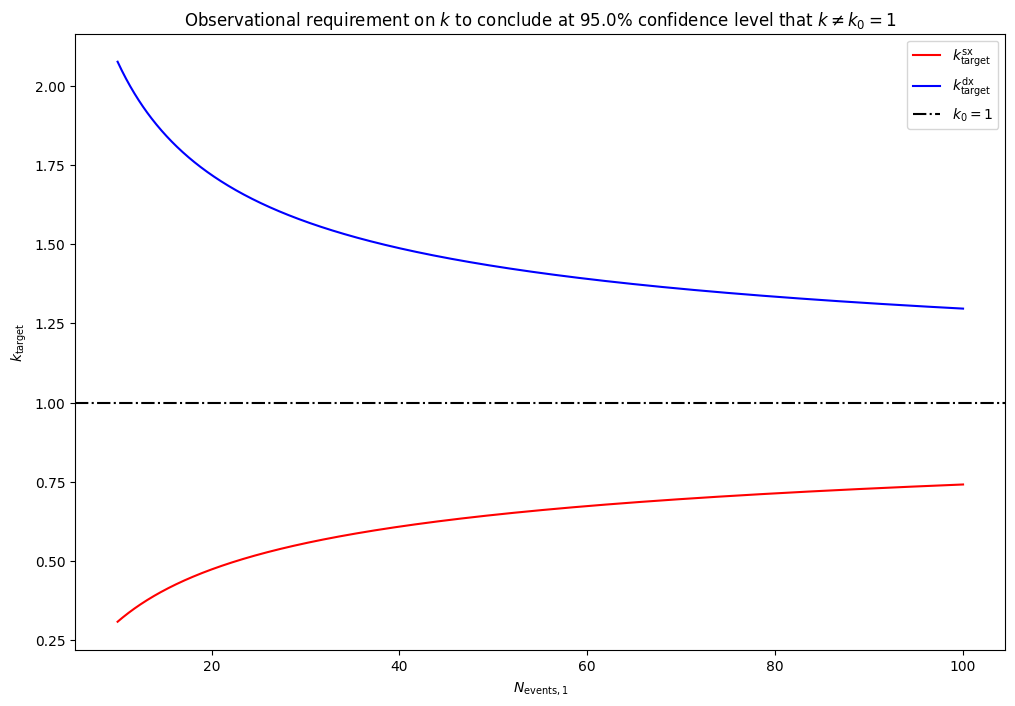

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'Observational requirement on $k$ to conclude at ${0}\%$ confidence level that $k \neq k_0 = {1}$'.format((1 - cl) * 100, k_0_target))

ax.set_xlabel(r'$N_{\text{events}, 1}$')
ax.set_ylabel(r'$k_\text{target}$')

ax.plot(N_1_events, k_target_sx, color='red', label=r'$k_\text{target}^\text{sx}$')
ax.plot(N_1_events, k_target_dx, color='blue', label=r'$k_\text{target}^\text{dx}$')
ax.axhline(k_0_target, linestyle='-.', color='black', label=r'$k_0 = {0}$'.format(k_0_target))

ax.legend()

plt.show()

### $\lambda_\text{LR}$ vs. $\text{p-value}$

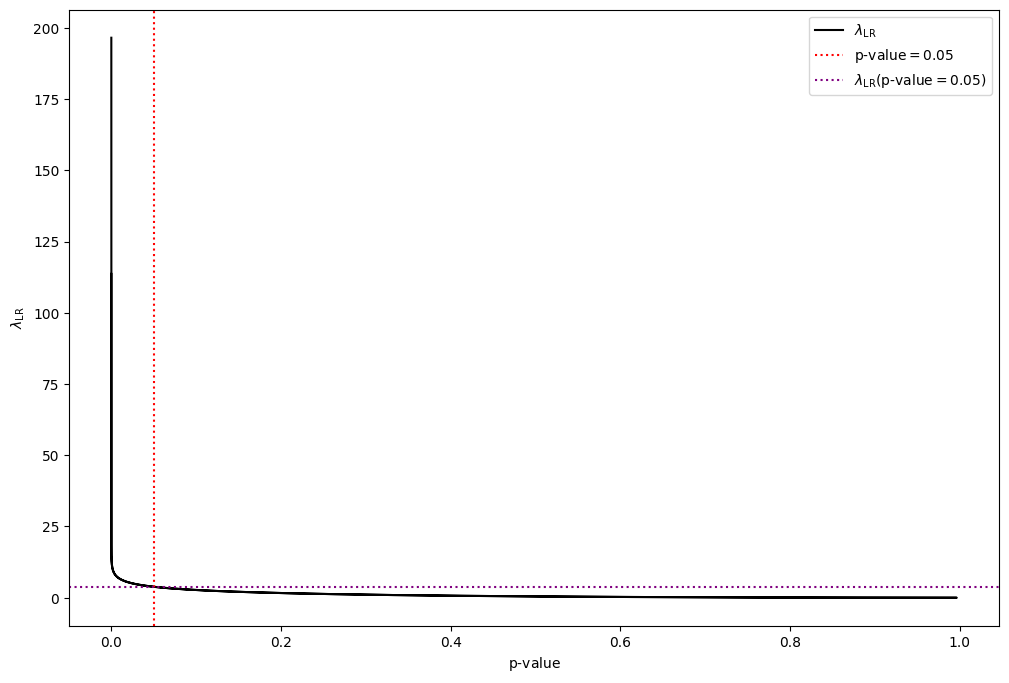

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_xlabel(r'$\text{p-value}$')
ax.set_ylabel(r'$\lambda_\text{LR}$')

ax.plot(p_value_LR, scipy.stats.chi2.isf(p_value_LR, 1), color='black', label=r'$\lambda_\text{LR}$')
ax.axvline(cl, linestyle=':', color='red', label=r'$\text{{p-value}} = {0}$'.format(cl))
ax.axhline(lambda_LR_target, linestyle=':', color='purple', label=r'$\lambda_\text{{LR}}(\text{{p-value}} = {0})$'.format(cl))

ax.legend()

plt.show()

## Connection with the merger rate

Inside a mass bin $\Delta m_i$:

$R(\Delta m_i) = N_i \left\langle \dfrac{1}{C(\theta, m, z)} \right\rangle_i$, where $\left\langle \dfrac{1}{C(\theta, m, z)} \right\rangle_i = \dfrac{1}{N_i} \sum_{j=1}^{N_i} \dfrac{1}{\langle C(\theta, m, z) \rangle_j}$,

$\langle C(\theta, m, z)\rangle_j = \int d\theta C(\theta, m, z) p(\theta | \text{data}_j) \simeq \dfrac{1}{M_j} \sum_{k=1}^{M_j} C(\theta_{j, k}, m_{j, k}, z_{j, k})$ and $M_j$ is the number of samples drawn from the posterior of the $j\text{-th}$ event.

$C(\theta, m, z) = T \int_0^{z_{\text{max}, i}} dz \dfrac{dV_c}{dz} \dfrac{p_\text{det}(\theta, m, z)}{1+z}$, $z_{\text{max}, i}$ is the maximum (observed/observable) redshift in the bin $\Delta m_i$.

Suppose two measurments of the merger rate in a certain mass bin $\Delta m_i$: $R_1(\Delta m_i)$ and $R_2(\Delta m_i)$.

Define $A_i = \dfrac{R_1(\Delta m_i)}{R_2(\Delta m_i)} = \alpha_i a_i$, where $\alpha_i = \dfrac{N_{1, i}}{N_{2, i}}$ and $a_i = \dfrac{\left\langle \dfrac{1}{C(\theta, m, z)} \right\rangle_{1, i}}{\left\langle \dfrac{1}{C(\theta, m, z)} \right\rangle_{2, i}}$

I want to test whether $A_i \neq A_0$ at a certain confidence level $\Longrightarrow$ test wheter $\alpha_i \neq \alpha_0 = \dfrac{A_0}{a_i}$. This approach should work because after the measurments, $a_i$ is just a number. Maybe see [this](https://lbelzile.github.io/math60604a/likelihood.html#sec-liktests).

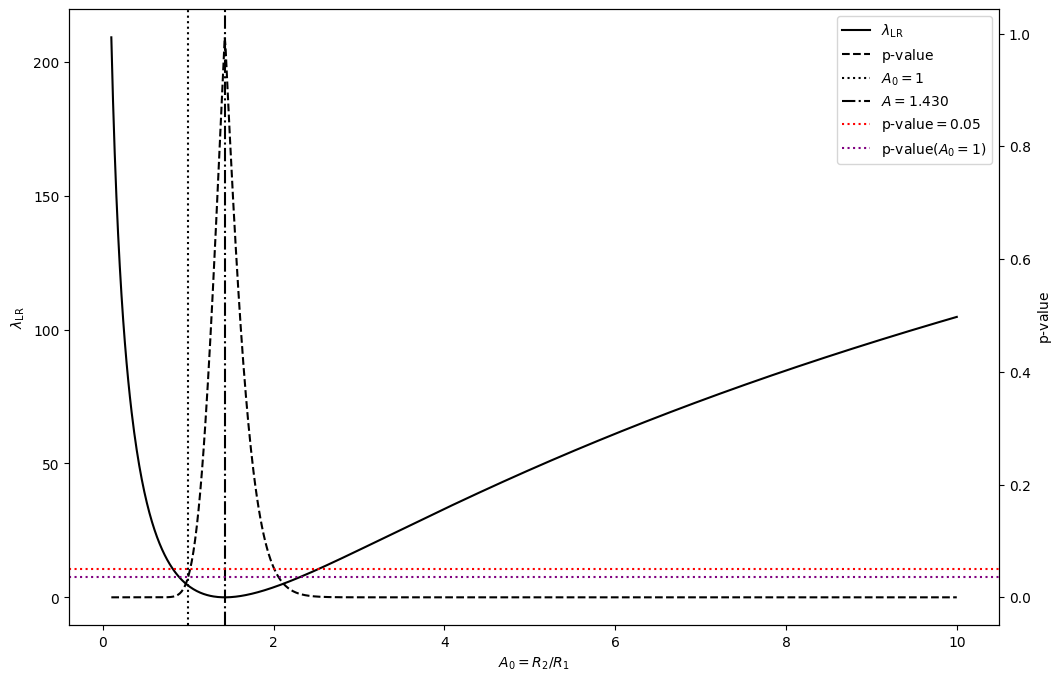

In [15]:
a = 1.1
A = k * a

A_0 = np.linspace(0.1, 10, 1000)

p_value_LR = scipy.stats.chi2.sf(lambda_LR(A_0 / a, k, expected_n_events_1), 1)

fig, ax = plt.subplots(figsize=(12, 8))

twin_ax = ax.twinx()

twin_ax.set_ylabel(r'$\text{p-value}$')

ax.set_xlabel(r'$A_0 = R_2 / R_1$')
ax.set_ylabel(r'$\lambda_\text{LR}$')

lines = []

lines.append(ax.plot(A_0, lambda_LR (A_0 / a, k, expected_n_events_1), color='black', label=r'$\lambda_\text{LR}$')[0])
lines.append(twin_ax.plot(A_0, p_value_LR, linestyle='--', color='black', label=r'$\text{p-value}$')[0])
lines.append(ax.axvline(1, linestyle=':', color='black', label=r'$A_0 = 1$'))
lines.append(ax.axvline(A, linestyle='-.', color='black', label=r'$A = {0}$'.format(np.format_float_positional(A, 3))))
lines.append(twin_ax.axhline(cl, linestyle=':', color='red', label=r'$\text{{p-value}} = {0}$'.format(cl)))
lines.append(twin_ax.axhline(scipy.stats.chi2.sf(lambda_LR(1 / a, k, expected_n_events_1), 1), linestyle=':', color='purple', label=r'$\text{p-value}(A_0 = 1)$'))

ax.legend(handles=lines)

plt.show()

### Solve for k, for a given a

Same procedure used before, just substitute $\alpha_0 = \dfrac{A_0}{a}$.

In [16]:
A_0_target = 1
k_eq = lambda x, expected_n_events_1: ((np.exp(lambda_LR_target / (2 * expected_n_events_1)) *\
                                        (1 + 1 / x) ** x * (1 + x)) ** (1 / (1 + x))) * (A_0_target / a) ** (x / (1 + x)) - (A_0_target / a) - 1

k_target_sx = find_root(k_eq, (0.1, A_0_target / a), args=(expected_n_events_1))
k_target_dx = find_root(k_eq, (A_0_target / a, 10), args=(expected_n_events_1))

print("k_target_sx = {0}\n"
      "k_0_target = {1}\n"
      "k_target_dx = {2}\n".format(k_target_sx.x, A_0_target / a, k_target_dx.x))

k_target_sx = 0.6054057554014147
k_0_target = 0.9090909090909091
k_target_dx = 1.272927470944459



In [17]:
k_target_sx = np.array([find_root(k_eq, (0.1, A_0_target / a), args=(n_events)).x for n_events in N_1_events])
k_target_dx = np.array([find_root(k_eq, (A_0_target / a, 10), args=(n_events)).x for n_events in N_1_events])

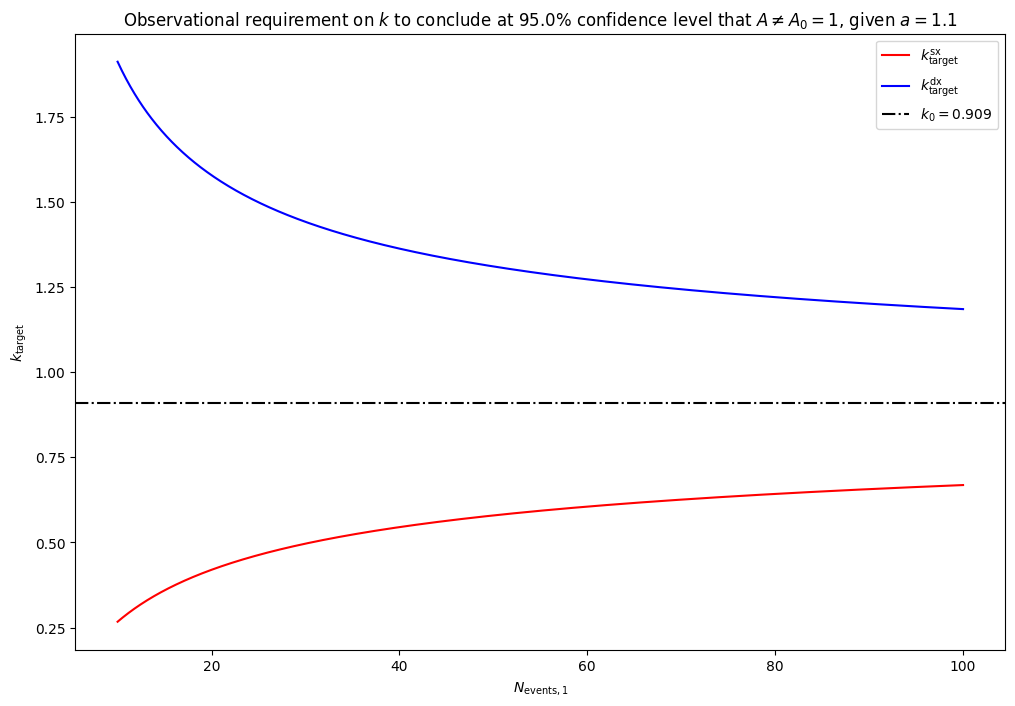

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'Observational requirement on $k$ to conclude at ${0}\%$ confidence level that $A \neq A_0 = {1}$, given $a = {2}$'.format((1 - cl) * 100, A_0_target, a))

ax.set_xlabel(r'$N_{\text{events}, 1}$')
ax.set_ylabel(r'$k_\text{target}$')

ax.plot(N_1_events, k_target_sx, color='red', label=r'$k_\text{target}^\text{sx}$')
ax.plot(N_1_events, k_target_dx, color='blue', label=r'$k_\text{target}^\text{dx}$')
ax.axhline(A_0_target / a, linestyle='-.', color='black', label=r'$k_0 = {0}$'.format(np.format_float_positional(A_0_target / a, 3)))

ax.legend()

plt.show()

### Solve for a

The equation is the same:
$$\xi \alpha_0^{\dfrac{\alpha}{1 + \alpha}} - \alpha_0 - 1 = 0$$
where
$$\xi = \left[\exp\left(\dfrac{\lambda_\text{LR}}{2 N_2}\right) \left(1 + \dfrac{1}{\alpha}\right)^\alpha \left(1 + \alpha\right)\right]^\dfrac{1}{1 + \alpha}$$

But this time I solve for $\alpha_0$ for a fixed value of $\alpha$ (on a $N_2$ grid) or $N_2$ (on a $\alpha$ grid).

In [19]:
k_0_eq_n1 = lambda x, expected_n_events_1: (np.exp(lambda_LR_target / (2 * expected_n_events_1)) *\
                                         (1 + 1 / k) ** k * (1 + k)) ** (1 / (1 + k)) * x ** (k / (1 + k)) - x - 1

k_0_sx_n1 = find_root(k_0_eq_n1, (0.1, k), args=(expected_n_events_1))
k_0_dx_n1 = find_root(k_0_eq_n1, (k, 10), args=(expected_n_events_1))

print("k_0_sx = {0}\n"
      "k_observed = {1}\n"
      "k_0_dx = {2}\n".format(k_0_sx_n1.x, k, k_0_dx_n1.x))

print("a_target_sx = {0}\n"
      "a_target = {1}\n"
      "k_target_dx = {2}\n".format(A_0_target / k_0_sx_n1.x, A_0_target / k, A_0_target / k_0_dx_n1.x))

k_0_sx = 0.930040323795343
k_observed = 1.3
k_0_dx = 1.8261222185117723

a_target_sx = 1.075222196731388
a_target = 0.7692307692307692
k_target_dx = 0.5476084732241887



In [20]:
k_0_sx_n1 = np.array([find_root(k_0_eq_n1, (0.1, k), args=(n_events)).x for n_events in N_1_events])
k_0_dx_n1 = np.array([find_root(k_0_eq_n1, (k, 10), args=(n_events)).x for n_events in N_1_events])

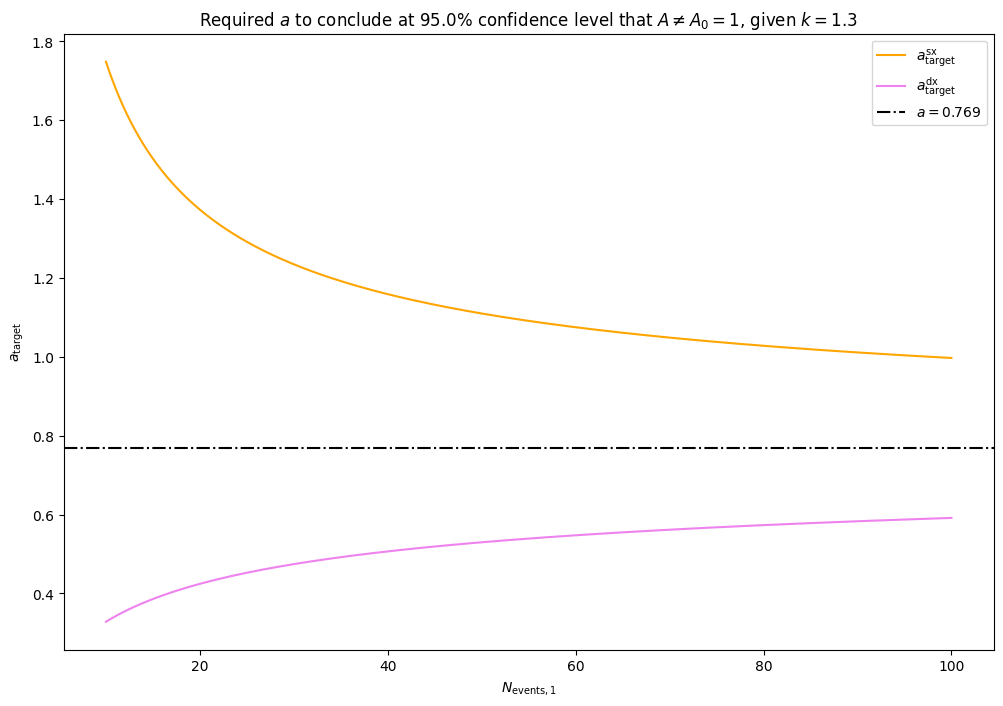

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'Required $a$ to conclude at ${0}\%$ confidence level that $A \neq A_0 = {1}$, given $k = {2}$'.format((1 - cl) * 100, A_0_target, k))

ax.set_xlabel(r'$N_{\text{events}, 1}$')
ax.set_ylabel(r'$a_\text{target}$')

ax.plot(N_1_events, A_0_target / k_0_sx_n1, color='orange', label=r'$a_\text{target}^\text{sx}$')
ax.plot(N_1_events, A_0_target / k_0_dx_n1, color='violet', label=r'$a_\text{target}^\text{dx}$')
ax.axhline(A_0_target / k, linestyle='-.', color='black', label=r'$a = {0}$'.format(np.format_float_positional(A_0_target / k, 3)))

# ax.plot(N_1_events, k_0_sx_n1, color='red', label=r'$k_0^\text{sx}$')
# ax.plot(N_1_events, k_0_dx_n1, color='blue', label=r'$k_0^\text{dx}$')
# ax.axhline(k, linestyle='-.', color='black', label=r'$k = {0}$'.format(np.format_float_positional(k, 3)))

ax.legend()

plt.show()

In [22]:
k_grid = np.linspace(0.1, 7, 1000)

k_0_eq_k = lambda x, k: (np.exp(lambda_LR_target / (2 * expected_n_events_1)) *\
                                         (1 + 1 / k) ** k * (1 + k)) ** (1 / (1 + k)) * x ** (k / (1 + k)) - x - 1

In [23]:
k_0_sx_k = np.array([find_root(k_0_eq_k, (0.1, k), args=(k)).x for k in k_grid])
k_0_dx_k = np.array([find_root(k_0_eq_k, (k, 10), args=(k)).x for k in k_grid])

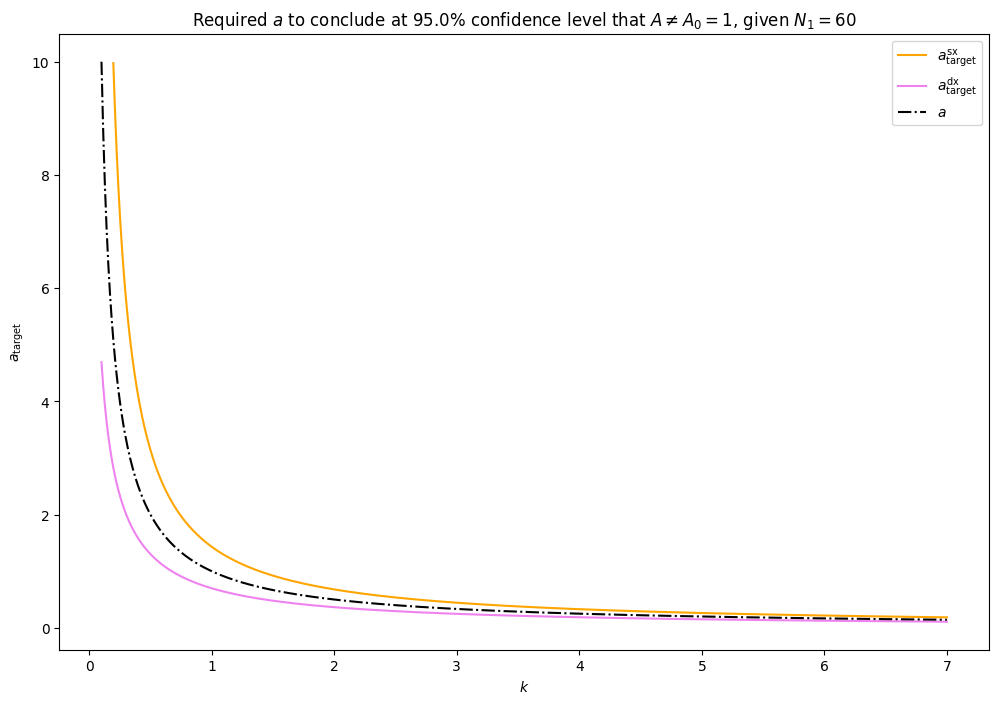

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'Required $a$ to conclude at ${0}\%$ confidence level that $A \neq A_0 = {1}$, given $N_1 = {2}$'.format((1 - cl) * 100, A_0_target, expected_n_events_1))

ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$a_\text{target}$')

ax.plot(k_grid, A_0_target / k_0_sx_k, color='orange', label=r'$a_\text{target}^\text{sx}$')
ax.plot(k_grid, A_0_target / k_0_dx_k, color='violet', label=r'$a_\text{target}^\text{dx}$')
ax.plot(k_grid, A_0_target / k_grid, linestyle='-.', color='black', label=r'$a$')

# ax.plot(k_grid, k_0_sx_k, color='red', label=r'$k_0^\text{sx}$')
# ax.plot(k_grid, k_0_dx_k, color='blue', label=r'$k_0^\text{dx}$')
# ax.axhline(A_0_target / k, linestyle='-.', color='black', label=r'$k = {0}$'.format(np.format_float_positional(k, 3)))

ax.legend()

plt.show()

### $z$ bins

How does the resul change when we look at different redshifts (in the same mass bin)?

$C(\theta, m, z)$ becomes:

$C(\theta, m, z) = T \int_{\Delta z_k} dz \dfrac{dV_c}{dz} \dfrac{p_\text{det}(\theta, m, z)}{1+z}$, where $\Delta z_k$ is the $k\text{-th}$ redshift bin.

Then:

$A_i = \dfrac{R_1(\Delta m_i, \Delta z_k)}{R_2(\Delta m_i, \Delta z_j)} = \alpha_{i, kj} a_{i, kj}$, where $\alpha_{i, kj} = \dfrac{N_{1, i, k}}{N_{2, i, j}}$ and $a_{i, kj} = \dfrac{\left\langle \dfrac{1}{C(\theta, m, z)} \right\rangle_{1, i, k}}{\left\langle \dfrac{1}{C(\theta, m, z)} \right\rangle_{2, i, j}}$

The ensamble average $\langle\rangle_{i,k}$ is computed only over the $i,k$ mass-redshift bin.

**Simple selection effect**

$p_\text{det} \propto (1 + z)^{-\beta}$

Inside a certain redshift bin, from $z$ to $z + d_z$:

$C \propto \int_z^{z + d_z} (1 + z')^{-\beta} dz' = \dfrac{(1 + z)^{1 - \beta}}{1 - \beta}\left[\left(1 + \dfrac{d_z}{1 + z}\right)^{1 - \beta} - 1\right]$ or $\ln\left(1 + \dfrac{d_z}{1 + z}\right)$ when $\beta = 1$

Approximately $d_z (1 + z)^{-\beta}$ for any $\beta$ when $\dfrac{d_z}{1 + z} \ll 1$.

In [25]:
d_z = 0.1
beta = 2
C_z = lambda z, d_z, beta: d_z * (1 + z) ** (-beta)

z_1, z_2 = 0.1, 0.2
(1 / C_z(z_2, d_z, beta)) / (1 / C_z(z_1, d_z, beta))

1.190082644628099

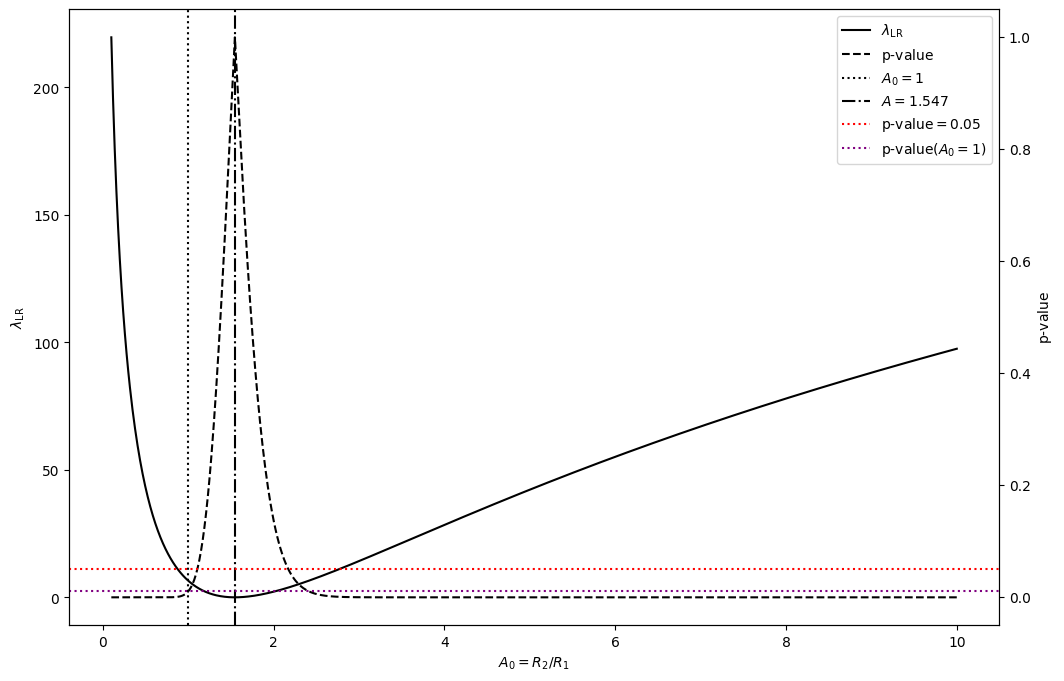

In [26]:
a = (1 / C_z(z_2, d_z, beta)) / (1 / C_z(z_1, d_z, beta))
A = k * a

A_0 = np.linspace(0.1, 10, 1000)

p_value_LR = scipy.stats.chi2.sf(lambda_LR(A_0 / a, k, expected_n_events_1), 1)

fig, ax = plt.subplots(figsize=(12, 8))

twin_ax = ax.twinx()

twin_ax.set_ylabel(r'$\text{p-value}$')

ax.set_xlabel(r'$A_0 = R_2 / R_1$')
ax.set_ylabel(r'$\lambda_\text{LR}$')

lines = []

lines.append(ax.plot(A_0, lambda_LR (A_0 / a, k, expected_n_events_1), color='black', label=r'$\lambda_\text{LR}$')[0])
lines.append(twin_ax.plot(A_0, p_value_LR, linestyle='--', color='black', label=r'$\text{p-value}$')[0])
lines.append(ax.axvline(1, linestyle=':', color='black', label=r'$A_0 = 1$'))
lines.append(ax.axvline(A, linestyle='-.', color='black', label=r'$A = {0}$'.format(np.format_float_positional(A, 3))))
lines.append(twin_ax.axhline(cl, linestyle=':', color='red', label=r'$\text{{p-value}} = {0}$'.format(cl)))
lines.append(twin_ax.axhline(scipy.stats.chi2.sf(lambda_LR(1 / a, k, expected_n_events_1), 1), linestyle=':', color='purple', label=r'$\text{p-value}(A_0 = 1)$'))

ax.legend(handles=lines)

plt.show()

In [27]:
k_target_sx = np.array([find_root(k_eq, (0.1, A_0_target / a), args=(n_events)).x for n_events in N_1_events])
k_target_dx = np.array([find_root(k_eq, (A_0_target / a, 10), args=(n_events)).x for n_events in N_1_events])

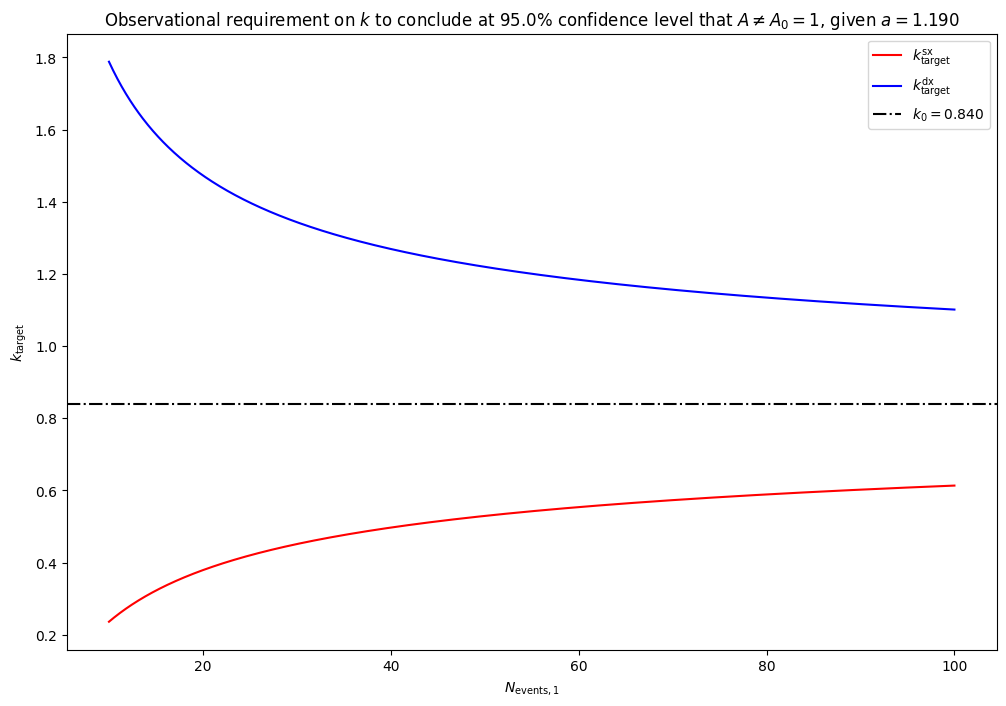

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'Observational requirement on $k$ to conclude at ${0}\%$ confidence level that $A \neq A_0 = {1}$, given $a = {2}$'.format((1 - cl) * 100, A_0_target, np.format_float_positional(a, 3)))

ax.set_xlabel(r'$N_{\text{events}, 1}$')
ax.set_ylabel(r'$k_\text{target}$')

ax.plot(N_1_events, k_target_sx, color='red', label=r'$k_\text{target}^\text{sx}$')
ax.plot(N_1_events, k_target_dx, color='blue', label=r'$k_\text{target}^\text{dx}$')
ax.axhline(A_0_target / a, linestyle='-.', color='black', label=r'$k_0 = {0}$'.format(np.format_float_positional(A_0_target / a, 3)))

ax.legend()

plt.show()

# Sampling

In [29]:
# PDF SAMPLING AND PLOTTING FUNCTIONS

#---------------------------------------------------------
# Compute a given PDF
#
# pdf: must be a callable that accepts x_grid as first positional parameter
# x_grid: the values over which the pdf has to be evaluated
# norm: whether to normalize numerically the PDF or not
# additional parameters are passed to pdf() through kwargs


def pdf_compute(pdf, x_grid, norm=False, **kwargs):
    y_pdf = pdf(x_grid, **kwargs)

    # Normalise the PDF if required
    if norm:
        norm = np.trapezoid(y_pdf, x_grid)
        y_pdf = y_pdf / norm
    
    return y_pdf

# Compute numerically the CDF of a given PDF along the x_grid
# The CDF is computed using the np.trapz() method
# Be aware of the limits of of np.trapz()
#
# parameters: see pdf_compute()
# norm: whether to normalize numerically the PDF or not
#       before computing the CDF
def cdf_compute_num(pdf, x_grid, norm=False, **kwargs):
    # Compute the pdf at each grid point
    y_pdf = pdf(x_grid, **kwargs)

    # Normalise the PDF if required
    if norm:
        norm = np.trapezoid(y_pdf, x_grid)
        y_pdf = y_pdf / norm

    # Compute the CDF by taking the cumulative integral on the grid points
    # array[:n] gives the first n terms of the array
    return np.array([np.trapezoid(y_pdf[:i+1], x_grid[:i+1]) for i in range(len(x_grid))])

# Compute a given PPF
#
# ppf: must be a callable that accepts P_grid as first positional parameter
# P_grid: the values over which the ppf has to be evaluated
#         They should be uniformly distributed random numbers between 0 and 1
# There is no norm parameter here because I hope that if you are lucky enough to have the CDF
# then it doens't need any adjustement (in reality I have no idea how to treat it at the present time,
# but this is a PDF oriented notebook afterall)
def ppf_compute(ppf, P_grid, **kwargs):
    return ppf(P_grid, **kwargs)

# A plotting utility to visualize a given PDF
#
# Same parameters as above plus the styling ones
#
# Returns the computed PDF to make the plot
def pdf_plotter(pdf, x_grid, norm=False,
                figsize=(12, 6), x_scale='linear', y_scale='linear',
                color=None,
                **kwargs):
    # Compute the PDF
    y_grid = pdf_compute(pdf, x_grid, norm=norm, **kwargs)

    # Plot the PDF
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(pdf.__name__)

    ax.plot(x_grid, y_grid, color=color)

    ax.set_xscale(x_scale)
    ax.set_yscale(y_scale)

    plt.show()

    # Return the computed PDF
    return y_grid

# A function that samples from a given PDF by performing
# a REJECTION SAMPLING technique
#
# pdf: the PDF from which to sample
# x_min, x_max, y_min, y_max: boundary of the box in which the rejection sampling is performed.
#                             the box should enclose completely the given pdf on the y axis.
#                             Choose a reasonable extension on the x axis to make a good sampling.
#                             BE AWARE OF WHAT YOU ARE SAMPLING!!
# size: the number of points to be sampled
# verbose: whether to print or not some diagnostic during the execution
# **kwargs: additional parameters to be passed to pdf()
#
# Returns the points sampled from the given PDF
def pdf_sampler(pdf,
                x_min, x_max, y_min, y_max,
                size=100, verbose=False, **kwargs):
    # Initialise the iteration counter
    iter_counter = 0

    # Initialise the array of sampled points and its lenght
    sampled_x = np.zeros(0)
    n_sample = len(sampled_x) # Number of sampled points
    
    # Sample until the desired number of points is reached
    while n_sample < size:
        # Generate (size - n_sample) uniformly distributed random numbers between 0 and 1
        x = np.random.uniform(x_min, x_max, size - n_sample)
        y = np.random.uniform(y_min, y_max, size - n_sample)

        # Get the PDF value for each of the x points
        # pdf_computed() here is not used to prevent an accidental parsing
        # of the norm parameter. Since 'x' can be very small in size normalizing is dangerous
        y_bound = pdf(x, **kwargs)

        # Append to the result array every x such that its y is smalle than its PDF
        # The '=' sign is necessary to account for limiting cases of constant pdf() functions
        sampled_x = np.append(sampled_x, x[y<=y_bound])

        # Compute the sampling efficiency of the performed iteration
        # i.e. how many point have been accepted out of the total generated (in the last iteration)
        samp_eff = 100 * len(x[y<=y_bound]) / (size - n_sample)

        # Update the number of sampled points and the iteration counter
        n_sample = len(sampled_x)
        iter_counter +=1

        # Print the diagnostic if required
        if verbose:
            # Build a diagnostic string
            diagnostic_str = ("Iteration {0}\n\n".format(iter_counter) +
                              "Sampling efficiency: {0} %\n".format(np.format_float_positional(samp_eff, 3)) +
                              "Sampled points: {0}\n".format(len(x[y<=y_bound])) +
                              "Progress: {0} out of {1}\n\n".format(n_sample, size))
            print(diagnostic_str)

    # Return the sampled points
    return sampled_x

# A plotting utility to visualize the sampled PDF
#
# pdf, x_grid: see pdf_plotter()
# sampled_x: the points sampled from the PDF (likely by pdf_sampler())
# norm: whether to normalize numerically the PDF or not
# quantiles: quantile lines to overplot on the samples distribution
# q_color: color of the quantiles
# q_styles: linestyle for each quantile
# styling parameters. 
# x_scale, y_scale: axis scales
# scale_unit: If given, the x axis will use scale_unit as the unit of the axis
# **kwargs: additional parameters to be passed to pdf()
def sampler_diagnostic_plot(pdf, x_grid, sampled_x, norm=False,
                            quantiles=[0.16, 0.5, 0.84], q_color='black', q_styles=[':', '-.', '--'],
                            figsize=(10, 8), bins='auto', histtype='stepfilled', color_plot=None, color_hist=None,
                            x_label=None, y_label=None,
                            x_scale='linear', y_scale='linear',
                            **kwargs):
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Plot the PDF
    ax.plot(x_grid, pdf_compute(pdf, x_grid, norm=norm, **kwargs), color=color_plot)

    ax.set_xscale(x_scale)
    ax.set_yscale(y_scale)

    # Plot the sampled PDF
    ax.hist(sampled_x, bins=bins, density=True, histtype=histtype, color=color_hist)

    # Compute and plot also some quantiles
    x_quantiles = np.quantile(sampled_x, quantiles)
    for q in range(len(quantiles)):
        ax.axvline(x_quantiles[q], color=q_color, linestyle=q_styles[q])

    return fig, ax

# A support function that genarates and returns support variables
#
# pdf: the PDF to use
# x_min, x_max: limits of the x_grid to be generated
# grid_n_points: number of points in the grid
# **kwargs: additional parameters to be passed to pdf()
#
# Returns a list: index 0: pdf
#                 index 1: [x_grid, y_grid]
#                 index 2: [x_min, y_min]
#                 index 3: [x_max, y_max]
#                 index 4: kwargs
def pdf_initialiser(pdf, x_min, x_max, grid_n_points=1000, **kwargs):
    x_grid = np.linspace(x_min, x_max, grid_n_points)
    y_grid = pdf(x_grid, **kwargs)

    y_min = np.min(y_grid)
    y_max = np.max(y_grid)

    return [pdf, [x_grid, y_grid], [x_min, y_min], [x_max, y_max], kwargs]

# Generates points in a sphere based on the given PDFs and their bounds
# pdf: the PDF to use
# bounds: list of 2 numbers: [min, max]
# size: the size of the sampling
# size_init: the size for the initialiser x_grid
#            Not important, here just for consistency
# pdf_args: dictionaries for additional arguments for the pdf() functions
#           Use dict(arg1=value1, arg2=value2, ...) to build them
def generate_spherical_points(pdf_r, r_bounds,
                              pdf_theta, theta_bounds,
                              pdf_phi, phi_bounds,
                              size=1, size_init=1000,
                              pdf_r_args={}, pdf_theta_args={}, pdf_phi_args={}):
    
    # Make ordered lists of the parameters
    pdf_list = [pdf_r, pdf_theta, pdf_phi]
    pdf_args_list = [pdf_r_args, pdf_theta_args, pdf_phi_args]
    bounds_list = [r_bounds, theta_bounds, phi_bounds]

    # Initialise all the PDF variables
    init_list = [pdf_initialiser(pdf_list[i], bounds_list[i][0], bounds_list[i][1],
                                 size_init, **pdf_args_list[i])
                                 for i in range(3)]

    # Sample from each PDF
    samples_list = [pdf_sampler(init_list[i][0],
                                init_list[i][2][0], init_list[i][3][0], init_list[i][2][1], init_list[i][3][1],
                                size=size, **init_list[i][4])
                                for i in range(3)]
    
    # Return the result as a (size, 3) shaped matrix
    return np.stack([samples_list[0], samples_list[1], samples_list[2]], axis=1)

# Computes the primitive of a function on a given grid:
# the integral of func from lower_limit to x for every x in x_grid or
# the integral of func from x to upper_limit for every x in x_grid
# Uses the quad() function from scipy
# func: the integrand, a callable whose first parameter is the independent variable
# x_grid: the grid on which the primitive is computed
# *kwargs: any positional parameter taken by func
# lower_limit, upper_limit: the integration limits. Must provide at least one and only one
def primitive_quad(func, x_grid, *kwargs, lower_limit=None, upper_limit=None):
    if (type(lower_limit) == type(None) and type(upper_limit) == type(None)) or\
        (type(lower_limit) != type(None) and type(upper_limit) != type(None)):
        raise ValueError("Specify limits or use quad directly for integration on fixed intervals")
    if type(upper_limit) != type(None):
        return np.array([scipy.integrate.quad(func, x_inf, upper_limit, args=kwargs)[0] for x_inf in x_grid])
    elif type(lower_limit) != type(None):
        return np.array([scipy.integrate.quad(func, lower_limit, x_up, args=kwargs)[0] for x_up in x_grid])

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_63775/1898589959.py:6: RuntimeWarning: divide by zero encountered in divide
  return result / norm


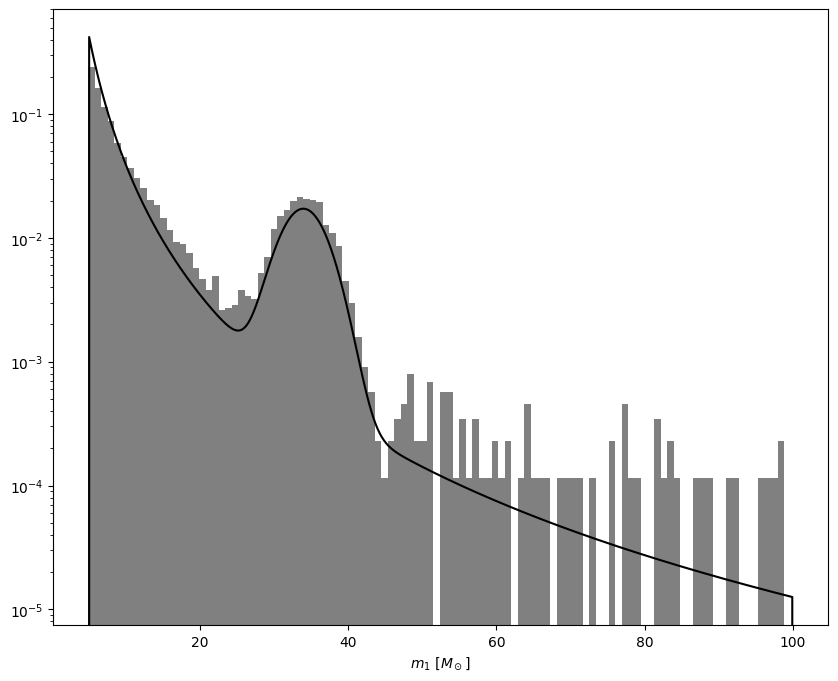

In [30]:
m1_init = pdf_initialiser(bbh_mass1_distribution, 5, 100,
                          alpha=alpha, mu_m1=mu_m1, sigma_m1=sigma_m1, f_p=f_p, M_min=M_min, M_max=M_max)

sampled_m1 = pdf_sampler(m1_init[0],
                        m1_init[2][0], m1_init[3][0], m1_init[2][1], m1_init[3][1],
                        size=10000, **m1_init[4], verbose=False)
fig, ax = sampler_diagnostic_plot(m1_init[0], m1_init[1][0], sampled_x=sampled_m1, **m1_init[4],
                                  color_plot='black', color_hist='gray', x_label=r'$m_1\ [M_\odot]$', quantiles=[])

ax.set_yscale('log')